# Reddit Climate Change - Modeling & Evaluation
Supervision: Prof. Dr. Jan Fabian Ehmke

Group members: Britz Luis, Huber Anja, Krause Felix Elias, Preda Yvonne-Nadine

Time: Summer term 2023 

Data: https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset

In [ ]:
#  Topic detection information material

# LDA
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# http://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

# BERTopic
# https://maartengr.github.io/BERTopic/index.html


## Preparing the Environment and Data

In [2]:
# Preparing environment
#%pip install bertopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
import pandas as pd
import re
import os

/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

In [3]:
# Load data
clean_comments = pd.read_csv("data/preprocessed_comments.csv")

/var/folders/94/kbz524cd32j80_2tm_hwnr780000gn/T/ipykernel_96121/3432851145.py:2: DtypeWarning: Columns (0,1,2,4,7,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_comments = pd.read_csv("data/preprocessed_comments.csv")


In [25]:
# Na rows are again created and should be removed
clean_comments = clean_comments.dropna(axis=0)

In [8]:
# Convert timestamp because import creates float variables
clean_comments["created_year"] = pd.to_datetime(clean_comments["created_date"]).dt.strftime('%Y')
clean_comments["created_month"] = pd.to_datetime(clean_comments["created_date"]).dt.strftime('%m')
clean_comments["created_day"] = pd.to_datetime(clean_comments["created_date"]).dt.strftime('%d')

In [42]:
# remove climate change as word
clean_comments["body_clean"] = clean_comments["body_clean"].apply(lambda x: re.sub("climate change", "", x, flags=re.IGNORECASE))

# Modeling Topic Clusters

In [43]:
# Create a subset of dataframe for every year
year_groups = clean_comments.groupby(clean_comments['created_year'])

year_dfs = {'comments_{}'.format(year): group for year, group in year_groups}

for year, group in year_groups:
    year_dfs[year] = group

In [44]:
# Create separate text documents per year
docs_2010 = year_dfs["comments_2010"]["body_clean"].values
docs_2011 = year_dfs["comments_2011"]["body_clean"].values
docs_2012 = year_dfs["comments_2012"]["body_clean"].values
docs_2013 = year_dfs["comments_2013"]["body_clean"].values
docs_2014 = year_dfs["comments_2014"]["body_clean"].values
docs_2015 = year_dfs["comments_2015"]["body_clean"].values
docs_2016 = year_dfs["comments_2016"]["body_clean"].values
docs_2017 = year_dfs["comments_2017"]["body_clean"].values
docs_2018 = year_dfs["comments_2018"]["body_clean"].values
docs_2019 = year_dfs["comments_2019"]["body_clean"].values
docs_2020 = year_dfs["comments_2020"]["body_clean"].values
docs_2021 = year_dfs["comments_2021"]["body_clean"].values
docs_2022 = year_dfs["comments_2022"]["body_clean"].values

In [53]:
# Create variables to train model separately per year
topic_models = {}
doc_tuples = [(2010, docs_2010), (2011, docs_2011), (2012, docs_2012), (2013, docs_2013), (2014, docs_2014), (2015, docs_2015), (2016, docs_2016), (2017, docs_2017), (2018, docs_2018), (2019, docs_2019), (2020, docs_2020), (2021, docs_2021), (2022, docs_2022)]

In [54]:
# Train model
for year, year_docs in doc_tuples:

  # BERT stepwise
  # Step 1 - Extract embeddings
  embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

  # Step 2 - Reduce dimensionality
  umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

  # Step 3 - Cluster reduced embeddings
  hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

  # Step 4 - Tokenize topics
  vectorizer_model = CountVectorizer(stop_words="english")

  # Step 5 - Create topic representation
  ctfidf_model = ClassTfidfTransformer()

  # All steps together
  topic_model = BERTopic(
    embedding_model=embedding_model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    calculate_probabilities=False,      # Raises speed
    min_topic_size = 300,               # Reduces number of topics
    nr_topics="auto",                    # Reduces number of topics
    verbose=True
  )

  topics, probs = topic_model.fit_transform(year_docs)
  topic_models[f"model_{year}"] = topic_model

Batches:   0%|          | 0/500 [00:00<?, ?it/s]

2023-05-08 13:25:33,175 - BERTopic - Transformed documents to Embeddings
2023-05-08 13:25:37,715 - BERTopic - Reduced dimensionality
2023-05-08 13:25:38,136 - BERTopic - Clustered reduced embeddings
2023-05-08 13:25:41,987 - BERTopic - Reduced number of topics from 103 to 16


Batches:   0%|          | 0/826 [00:00<?, ?it/s]

2023-05-08 13:33:01,008 - BERTopic - Transformed documents to Embeddings
2023-05-08 13:33:07,232 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 13:33:08,508 - BERTopic - Clustered reduced embeddings
2023-05-08 13:33:14,824 - BERTopic - Reduced number of topics from 154 to 41


Batches:   0%|          | 0/1490 [00:00<?, ?it/s]

2023-05-08 13:44:18,296 - BERTopic - Transformed documents to Embeddings
2023-05-08 13:44:32,605 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 13:44:34,460 - BERTopic - Clustered reduced embeddings
2023-05-08 13:44:43,864 - BERTopic - Reduced number of topics from 222 to 52


Batches:   0%|          | 0/4979 [00:00<?, ?it/s]

2023-05-08 14:04:49,893 - BERTopic - Transformed documents to Embeddings
2023-05-08 14:05:53,119 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 14:06:01,660 - BERTopic - Clustered reduced embeddings
2023-05-08 14:06:15,340 - BERTopic - Reduced number of topics from 235 to 54


Batches:   0%|          | 0/3932 [00:00<?, ?it/s]

2023-05-08 14:32:22,067 - BERTopic - Transformed documents to Embeddings
2023-05-08 14:33:06,424 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 14:33:11,750 - BERTopic - Clustered reduced embeddings
2023-05-08 14:33:34,329 - BERTopic - Reduced number of topics from 379 to 289


Batches:   0%|          | 0/3111 [00:00<?, ?it/s]

2023-05-08 14:57:36,753 - BERTopic - Transformed documents to Embeddings
2023-05-08 14:58:04,258 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 14:58:07,949 - BERTopic - Clustered reduced embeddings
2023-05-08 14:58:29,773 - BERTopic - Reduced number of topics from 424 to 327


Batches:   0%|          | 0/3113 [00:00<?, ?it/s]

2023-05-08 15:22:11,716 - BERTopic - Transformed documents to Embeddings
2023-05-08 15:22:37,874 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 15:22:41,520 - BERTopic - Clustered reduced embeddings
2023-05-08 15:23:02,772 - BERTopic - Reduced number of topics from 410 to 333


Batches:   0%|          | 0/3111 [00:00<?, ?it/s]

2023-05-08 15:46:03,354 - BERTopic - Transformed documents to Embeddings
2023-05-08 15:46:29,298 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 15:46:32,944 - BERTopic - Clustered reduced embeddings
2023-05-08 15:46:51,912 - BERTopic - Reduced number of topics from 412 to 63


Batches:   0%|          | 0/3110 [00:00<?, ?it/s]

2023-05-08 16:40:20,153 - BERTopic - Transformed documents to Embeddings
2023-05-08 16:40:43,463 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 16:40:46,815 - BERTopic - Clustered reduced embeddings
2023-05-08 16:48:52,229 - BERTopic - Reduced number of topics from 410 to 184


Batches:   0%|          | 0/3107 [00:00<?, ?it/s]

2023-05-08 19:28:30,598 - BERTopic - Transformed documents to Embeddings
2023-05-08 19:28:55,843 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 19:28:59,457 - BERTopic - Clustered reduced embeddings
2023-05-08 19:29:19,090 - BERTopic - Reduced number of topics from 422 to 315


Batches:   0%|          | 0/3108 [00:00<?, ?it/s]

2023-05-08 19:51:30,335 - BERTopic - Transformed documents to Embeddings
2023-05-08 19:51:56,266 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 19:52:00,060 - BERTopic - Clustered reduced embeddings
2023-05-08 19:52:19,642 - BERTopic - Reduced number of topics from 429 to 103


Batches:   0%|          | 0/3105 [00:00<?, ?it/s]

2023-05-08 20:13:49,784 - BERTopic - Transformed documents to Embeddings
2023-05-08 20:14:15,430 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 20:14:19,076 - BERTopic - Clustered reduced embeddings
2023-05-08 20:14:37,541 - BERTopic - Reduced number of topics from 428 to 64


Batches:   0%|          | 0/3098 [00:00<?, ?it/s]

2023-05-08 21:18:19,875 - BERTopic - Transformed documents to Embeddings
2023-05-08 21:18:45,430 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-05-08 21:18:49,101 - BERTopic - Clustered reduced embeddings
2023-05-08 21:19:07,546 - BERTopic - Reduced number of topics from 430 to 104


### Saving Model as CSV

In [72]:
# Save model as CSV file
for year in range(2010, 2023):
    model_name = f"model_{year}"
    docs_name = f"docs_{year}"
    file_name = f"data/model{year}.csv"
    topic_models[model_name].get_document_info(globals()[docs_name]).to_csv(file_name)

### Save Topic information as CSV file

In [166]:
# Save model as CSV file
for year in range(2010, 2023):
    model_name = f"model_{year}"
    file_name = f"data/topics_{year}.csv"
    topic_models[model_name].get_topic_info().to_csv(file_name)

### Combine Dataset with Detected Topics

In [151]:
for year in range(2010, 2023):
    # Create dataframes to be joined and drop irrelevant columns from topic dataframe, set indexes for join
    topic_data = topic_models[f"model_{year}"].get_document_info(globals()[f"docs_{year}"])
    topic_data = topic_data.drop(["Document","Probability","Representative_document"], axis=1).reset_index()

    original_data = year_dfs[f"comments_{year}"].reset_index(drop=True).reset_index()

    # Join Columns
    joined_df = original_data.join(topic_data,on='index',how='left',rsuffix='_topics')

    # Set the name of the joined dataframe
    joined_df_name = f"joined_{year}"

    # Add the joined dataframe to the global namespace
    globals()[joined_df_name] = joined_df


In [173]:
# Putting all dataframes back together
# List of joined dataframe names
joined_df_names = [f"joined_{year}" for year in range(2010, 2023)]

# List of joined dataframes
joined_dfs = [globals()[df_name] for df_name in joined_df_names]

# Concatenate the joined dataframes row-wise
concatenated_df = pd.concat(joined_dfs, axis=0, ignore_index=True)

In [179]:
# Drop and rename columns
concatenated_df = concatenated_df.drop(["index", "index_topics"], axis=1)
concatenated_df = concatenated_df.rename(columns={'Topic': 'topic_number', 'Name': 'topic_name', 'Top_n_words': 'topic_most_used_words'})

### Saving Model Outputs

In [181]:
# Save "comments" CSV file in data folder
comments_save_path = f"data/comments_with_topics.csv"

if not os.path.isfile(comments_save_path):
    concatenated_df.to_csv("data/comments_with_topics.csv")
    print("File saved!")
else:
    print("Warning: file already exists")

### Fist Insights

In [220]:
data = pd.read_csv("data/comments_with_topics.csv")

In [223]:
# Only take the most frequent topics into account, Sorting out 0 since it has too much effect on visuals, sorts our outlier topics too
test = data[(data["topic_number"]> 0) & (data["topic_number"]<= 10)]

In [163]:
# Check for Na values
test.isna().sum().sum()

0

In [226]:
topic_models["model_2010"].get_document_info(docs_2010)

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,Industrial output --; Increased atmospheric CO...,-1,-1_climate_people_global_warming,climate - people - global - warming - just - s...,0.000000,False
1,This is true but only because Australia lacks ...,0,0_people_just_climate_global,people - just - climate - global - don - like ...,0.173918,False
2,"Please, explain to us the whole concept.\n\nNe...",-1,-1_climate_people_global_warming,climate - people - global - warming - just - s...,0.000000,False
3,"It hasn't been ""Changed"" some political types ...",0,0_people_just_climate_global,people - just - climate - global - don - like ...,1.000000,False
4,"; It's called """" or as the right wing has dubb...",0,0_people_just_climate_global,people - just - climate - global - don - like ...,1.000000,False
...,...,...,...,...,...,...
15981,; We have no history - ours goes back only y...,-1,-1_climate_people_global_warming,climate - people - global - warming - just - s...,0.000000,False
15982,Changing the oil *filter* every single time yo...,-1,-1_climate_people_global_warming,climate - people - global - warming - just - s...,0.000000,False
15983,"A man who though a moderate Tory , has a mixed...",0,0_people_just_climate_global,people - just - climate - global - don - like ...,0.549953,False
15984,Both Iggy and Harper would have marched us int...,0,0_people_just_climate_global,people - just - climate - global - don - like ...,1.000000,False


In [200]:
# Import Plotting Library
import matplotlib.pyplot as plt

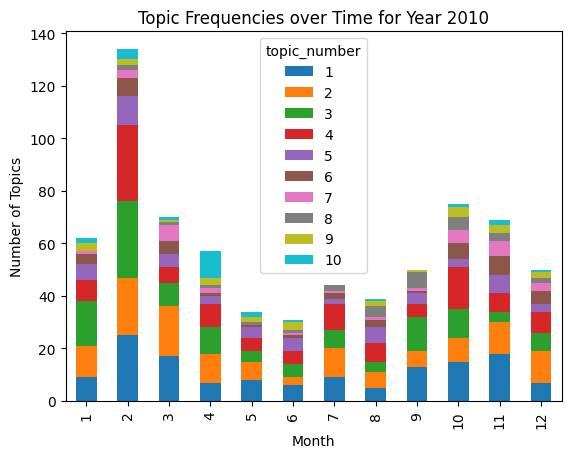

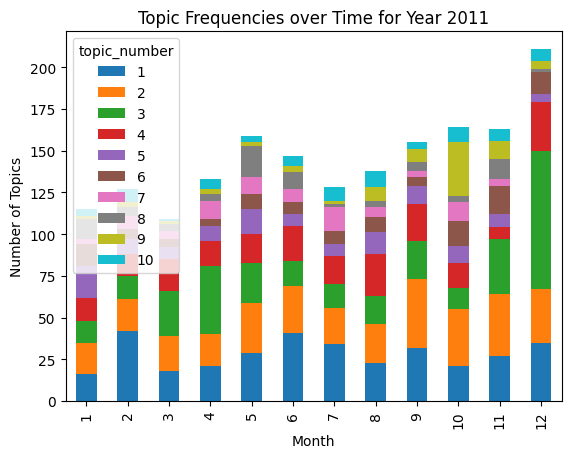

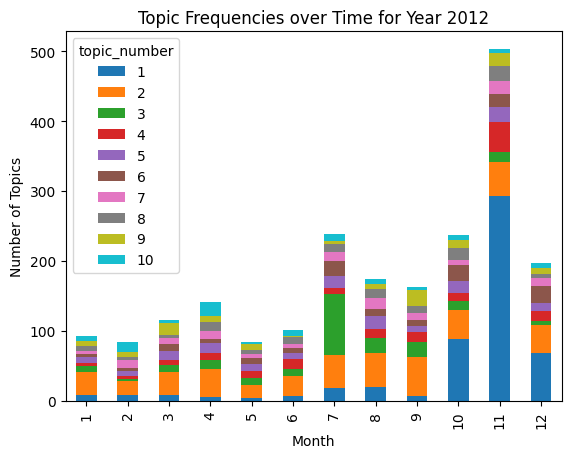

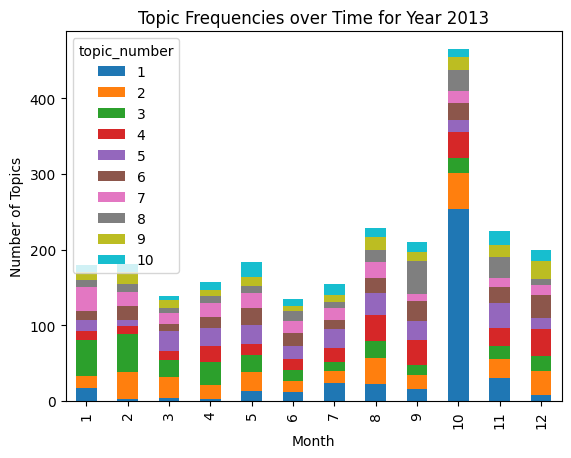

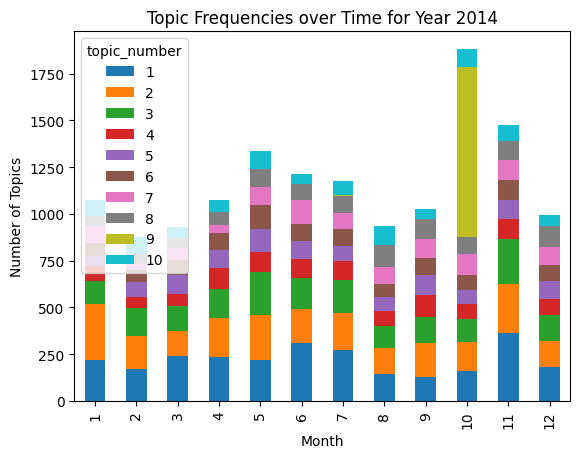

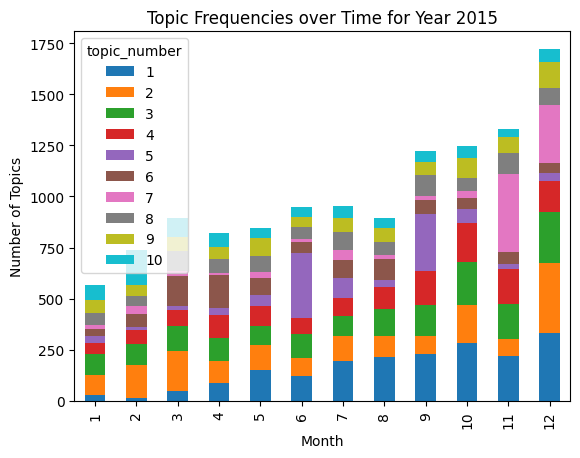

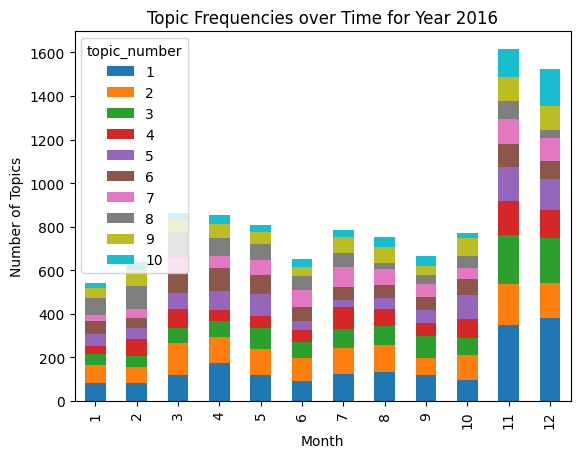

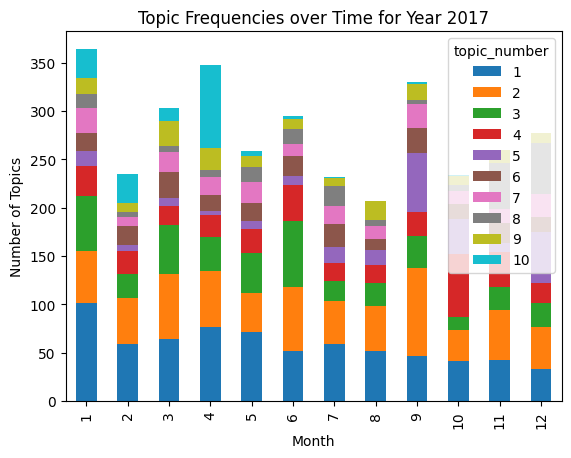

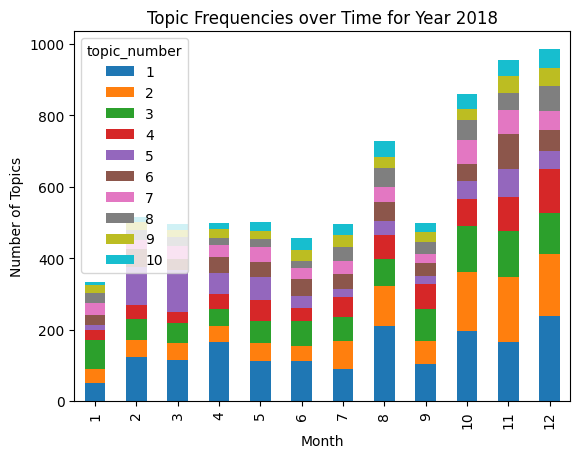

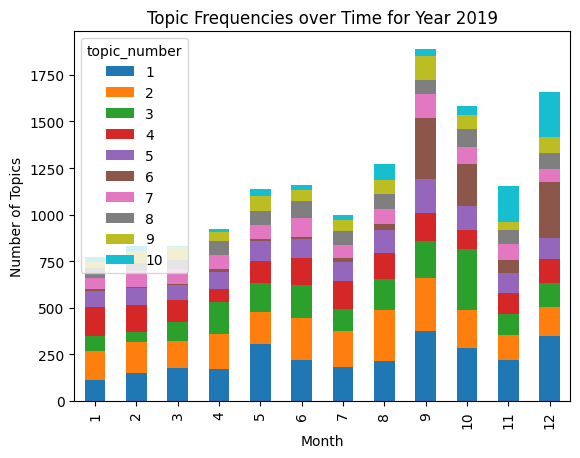

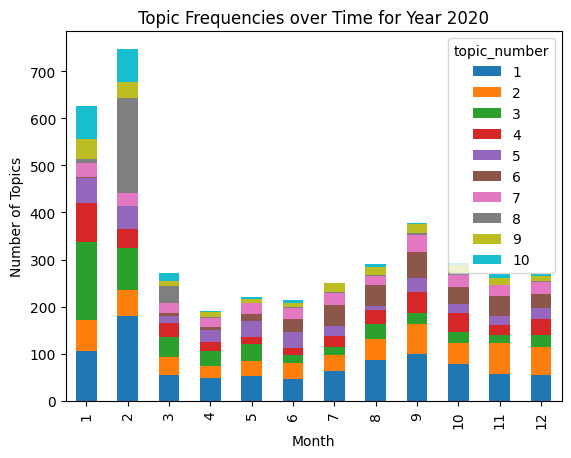

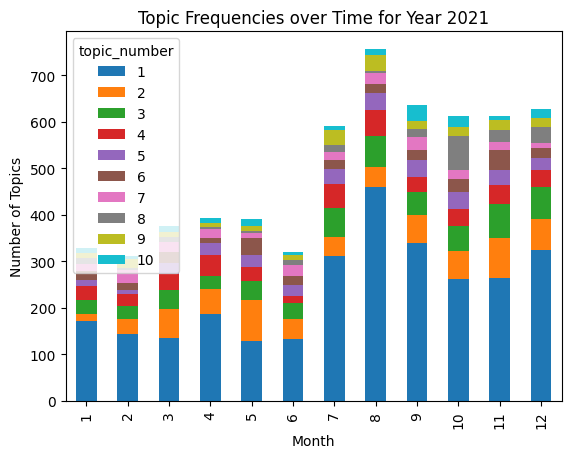

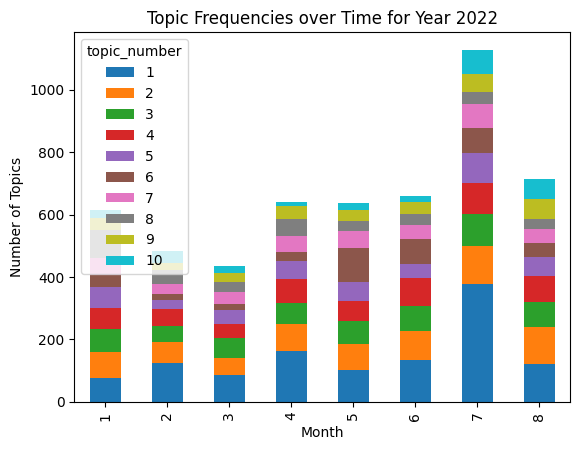

In [224]:
# Create plot for every year
for year in range (2010, 2023):

    # filter the DataFrame to include only the specified year
    df = test[test['created_year'] == year]

    # aggregate the data by date and topic number
    counts = df.groupby(['created_month', 'topic_number']).size().unstack(fill_value=0)

    # plot the stacked bar chart
    counts.plot(kind='bar', stacked=True)
    plt.xlabel('Month')
    plt.ylabel('Number of Topics')
    plt.title(f'Topic Frequencies over Time for Year {year}')
    plt.show()
